#### Introduction

This classification of waste images (25077 total, 20062 training - 80%, 5015 testing - 20%) involves building three models; MLP, MobileNetV2, and CNN. 
Then evaluating all three models by ensembling them in an ensemble. And finally comparing 
all models to see the best performance for deployment in real-life waste classification into organic or recyclable wastes.

### Building Multi Layer Perceptron (MLP) Model for Waste Classification

In [1]:
#importing the necessary libraries for use

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
import pathlib
import warnings

In [2]:
#Loading the dataset and assigning path
data_path = "C:/Users/Helen/Downloads/Waste Classification Data"

In [3]:
#setting parameters for pre-processing data
batch_size = 32
img_height = 180
img_width = 180

In [4]:
#Assigning the preprocessed data to a training dataset variable with parameters
#identifying the classes in the dataset
#splitting dataset into training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path,validation_split=0.2,subset="training",seed=123,
image_size=(img_height, img_width),batch_size=batch_size)

Found 25077 files belonging to 2 classes.
Using 20062 files for training.


In [5]:
#Assigning the preprocessed data to a validating dataset variable with parameters
#identifying the classes in the dataset
#splitting dataset into validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path,validation_split=0.2,subset="validation",seed=123,
image_size=(img_height, img_width),batch_size=batch_size)

Found 25077 files belonging to 2 classes.
Using 5015 files for validation.


In [6]:
#Assigning & printing the class names in the training dataset
class_names = train_ds.class_names
print(class_names)

['Organic', 'Recyclable']


In [7]:
#Autotuning & normalization to allow for optimum performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#rescalaing data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
num_classes = 2

0.0 1.0


In [8]:
#Building the MLP model with keras

mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(180, 180, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

#compiling the MLP model
mlp_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

#printing the summary
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense (Dense)               (None, 128)               12441728  
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 12443018 (47.47 MB)
Trainable params: 12443018 (47.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
#train MLP model
mlp_model = mlp_model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
627/627 [==============================] - 137s 214ms/step - loss: 1052.3746 - accuracy: 0.7104 - val_loss: 4604.0015 - val_accuracy: 0.5051
Epoch 2/5
627/627 [==============================] - 147s 235ms/step - loss: 611.7566 - accuracy: 0.7255 - val_loss: 484.6757 - val_accuracy: 0.7803
Epoch 3/5
627/627 [==============================] - 142s 226ms/step - loss: 303.1448 - accuracy: 0.7290 - val_loss: 160.0102 - val_accuracy: 0.7482
Epoch 4/5
627/627 [==============================] - 146s 233ms/step - loss: 132.6479 - accuracy: 0.7367 - val_loss: 56.5397 - val_accuracy: 0.7573
Epoch 5/5
627/627 [==============================] - 151s 241ms/step - loss: 63.8371 - accuracy: 0.7423 - val_loss: 28.5340 - val_accuracy: 0.7707


In [10]:
#evaluate the MLP model on the training set
test_loss, test_acc = mlp_model.model.evaluate(train_ds, verbose=2)
print('\nTest accuracy:', test_acc)

627/627 - 52s - loss: 20.5985 - accuracy: 0.8131 - 52s/epoch - 83ms/step

Test accuracy: 0.8131293058395386


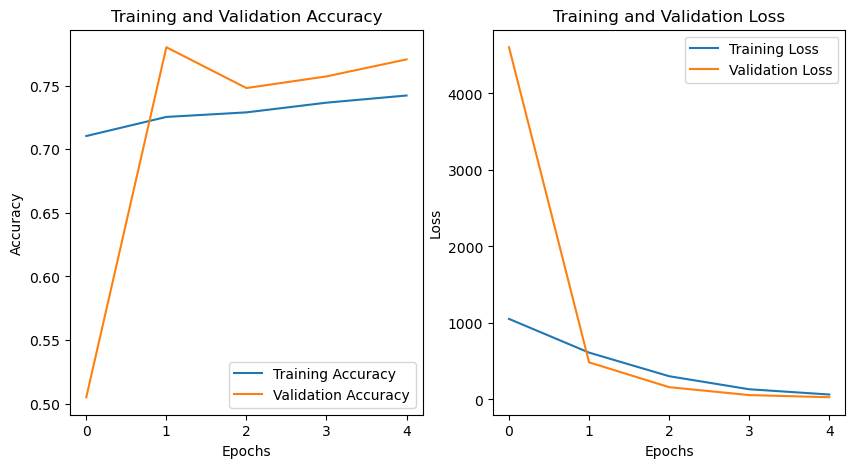

In [11]:
#Visualize loss & accuracy of the MLP model
epochs = 5
acc = mlp_model.history['accuracy']
val_acc = mlp_model.history['val_accuracy']
loss = mlp_model.history['loss']
val_loss = mlp_model.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [12]:
# Evaluate the MLP model on the validation set
val_loss, val_accuracy = mlp_model.model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")

157/157 [==============================] - 14s 91ms/step - loss: 28.5340 - accuracy: 0.7707
Validation accuracy: 0.7707


In [13]:
# Predict classes for the validation set
val_pred_probs_mlp = mlp_model.model.predict(val_ds)
val_pred_classes_mlp = np.argmax(val_pred_probs_mlp, axis=1)

157/157 [==============================] - 4s 19ms/step


MLP Model Classification Report:
               precision    recall  f1-score   support

     organic       0.81      0.75      0.78      2727
  recyclable       0.73      0.79      0.76      2288

    accuracy                           0.77      5015
   macro avg       0.77      0.77      0.77      5015
weighted avg       0.77      0.77      0.77      5015



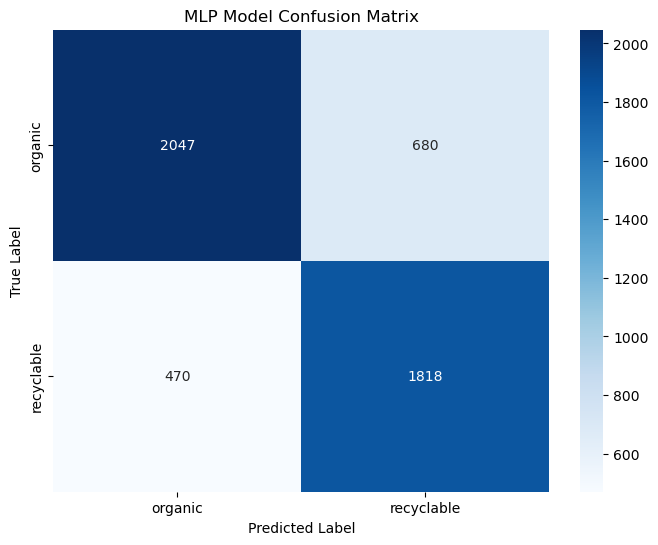

In [149]:
#Evaluate the MLP model's performance

#Import the evaluation report & metrics
from sklearn.metrics import classification_report, confusion_matrix

# Extract true class labels from the directory structure
val_true_classes = []
for _, labels in val_ds:
    val_true_classes.extend(labels.numpy())  # Extract true labels

# Define class names
class_names = ['organic', 'recyclable']

# Print classification report
report = classification_report(val_true_classes, val_pred_classes_mlp, target_names=class_names)
print("MLP Model Classification Report:\n", report)

# Calculate confusion matrix
confusion_mat = confusion_matrix(val_true_classes, val_pred_classes_mlp)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MLP Model Confusion Matrix')
plt.show()

(32, 180, 180, 3)
(32,)


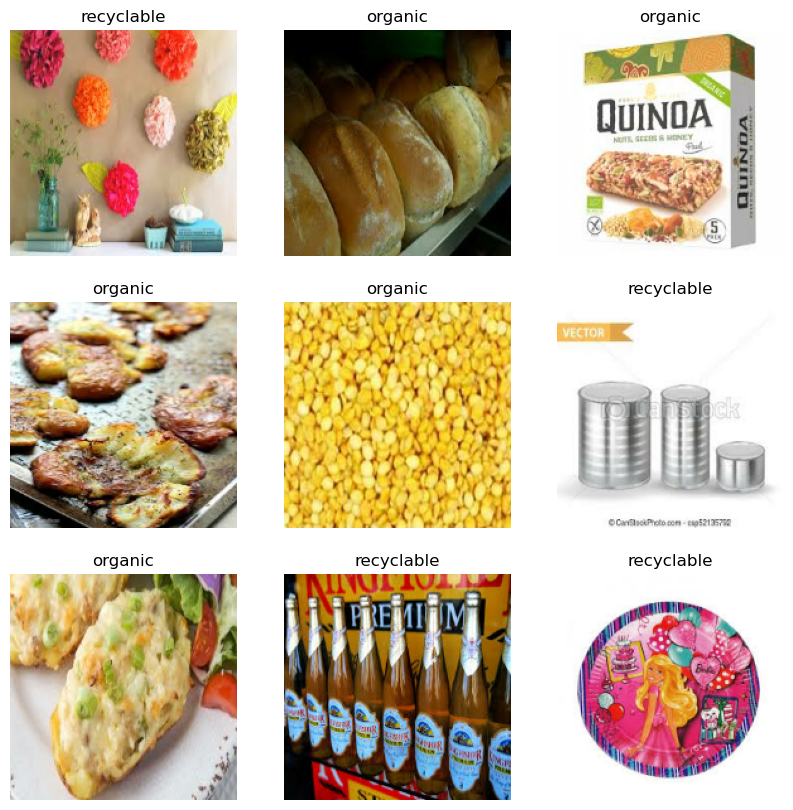

In [15]:
#printing sample waste images (labels) from the train_ds

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


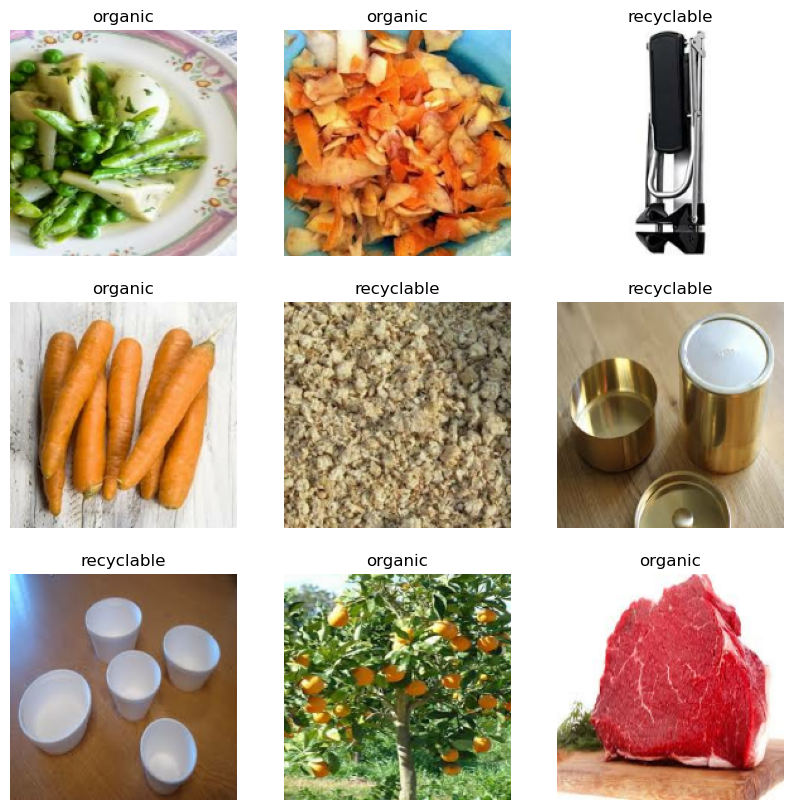

In [16]:
#printing sample waste images (labels) from the val_ds

plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

### Building Pre-Trained Model, MobileNetV2

In [17]:
#importing the necessary libraries for use

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
import pathlib
import warnings

In [18]:
#Loading the dataset and assigning path
data_path2 = "C:/Users/Helen/Downloads/Waste Classification Data"

In [19]:
#setting parameters for pre-processing data
batch_size = 32
img_height = 224
img_width = 224

In [20]:
#Assigning the preprocessed data to a training dataset variable with parameters
#identifying the classes in the dataset
#splitting dataset into training set
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(data_path2,validation_split=0.2,subset="training",seed=123,
image_size=(img_height, img_width),batch_size=batch_size)

Found 25077 files belonging to 2 classes.
Using 20062 files for training.


In [21]:
#Assigning the preprocessed data to a validating dataset variable with parameters
#identifying the classes in the dataset
#splitting dataset into validation set
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(data_path2,validation_split=0.2,subset="validation",seed=123,
image_size=(img_height, img_width),batch_size=batch_size)

Found 25077 files belonging to 2 classes.
Using 5015 files for validation.


In [22]:
#Assigning & printing the class names in the training dataset
class_names = train_ds2.class_names
print(class_names)

['Organic', 'Recyclable']


In [23]:
#Autotuning & normalization to allow for optimum performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)

#rescalaing data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
num_classes = 2

0.0 1.0


In [24]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = 224, 224
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

In [25]:
 
# image_batch, label_batch = next(iter(train_ds))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape) 

resized_images = tf.image.resize(image_batch, (224, 224))
feature_batch = base_model(resized_images)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [26]:
#print model summary
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [27]:
#applying global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [28]:
#Adding dense layer<>prediction layer
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [29]:
#input process setup
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

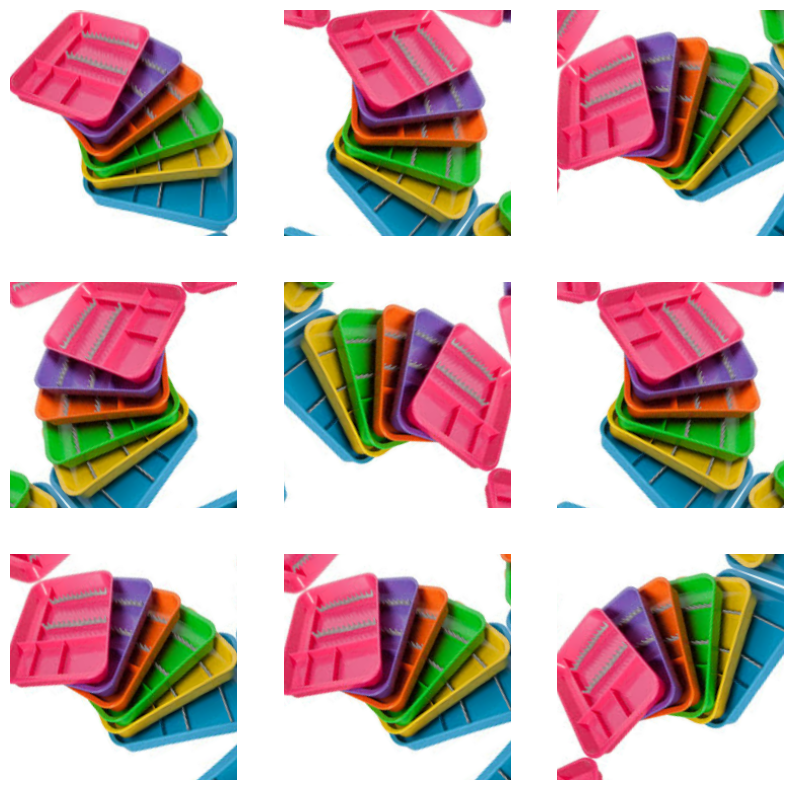

In [30]:
#applying data augmentation

data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),])

for image, _ in train_ds2.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [31]:
#setting up the inputs
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
mnetv2_model = tf.keras.Model(inputs, outputs) 

In [32]:
#compiling the base model, MobileNetV2
base_learning_rate = 0.0001
mnetv2_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [33]:
#Summarizing the base model, MobileNetV2
mnetv2_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [34]:
#checking the class length trainable
len(mnetv2_model.trainable_variables)

2

In [35]:
#Training the model, MobileNetV2
mnetv2_model = mnetv2_model.fit(train_ds2,epochs=5,validation_data=val_ds2)

Epoch 1/5
627/627 [==============================] - 1211s 2s/step - loss: 0.2635 - accuracy: 0.8963 - val_loss: 0.2120 - val_accuracy: 0.9174
Epoch 2/5
627/627 [==============================] - 1197s 2s/step - loss: 0.2119 - accuracy: 0.9207 - val_loss: 0.1855 - val_accuracy: 0.9308
Epoch 3/5
627/627 [==============================] - 1186s 2s/step - loss: 0.2083 - accuracy: 0.9242 - val_loss: 0.1833 - val_accuracy: 0.9340
Epoch 4/5
627/627 [==============================] - 748s 1s/step - loss: 0.2087 - accuracy: 0.9228 - val_loss: 0.1730 - val_accuracy: 0.9344
Epoch 5/5
627/627 [==============================] - 756s 1s/step - loss: 0.2076 - accuracy: 0.9230 - val_loss: 0.1755 - val_accuracy: 0.9324


In [36]:
#Evaluate the MobilNetV2 model on the training set
test_loss, test_acc = mnetv2_model.model.evaluate(train_ds2, verbose=2)
print('\nTest accuracy:', test_acc)

627/627 - 558s - loss: 0.1591 - accuracy: 0.9419 - 558s/epoch - 890ms/step

Test accuracy: 0.9418801665306091


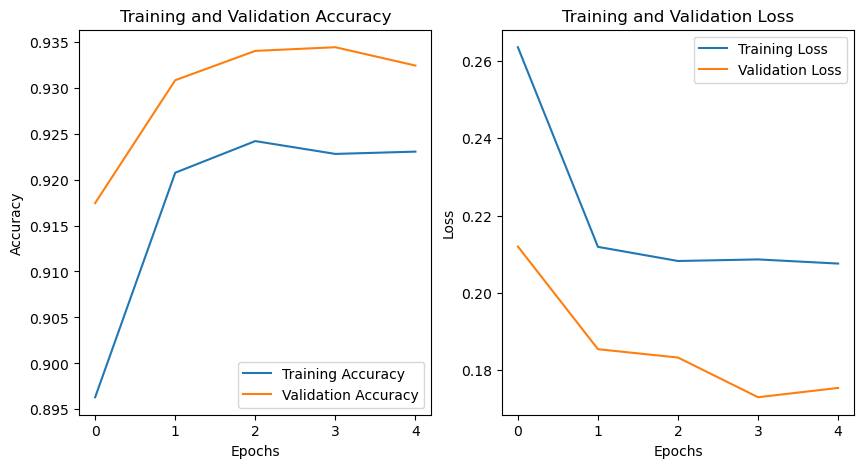

In [37]:
#Visualize loss & accuracy of the MobileNetV2 model
epochs = 5
acc = mnetv2_model.history['accuracy']
val_acc = mnetv2_model.history['val_accuracy']
loss = mnetv2_model.history['loss']
val_loss = mnetv2_model.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [38]:
# Evaluate the MobileNetV2 model on the validation set
val_loss, val_accuracy = mnetv2_model.model.evaluate(val_ds2)
print(f"Validation accuracy: {val_accuracy:.4f}")

157/157 [==============================] - 138s 881ms/step - loss: 0.1755 - accuracy: 0.9324
Validation accuracy: 0.9324


In [39]:
# Predict classes for the validation set
val_pred_probs_mnetv2 = mnetv2_model.model.predict(val_ds2)
val_pred_classes_mnetv2 = np.argmax(val_pred_probs_mnetv2, axis=1)

157/157 [==============================] - 133s 835ms/step


MobileNetV2 Model Classification Report:
               precision    recall  f1-score   support

     organic       0.94      0.94      0.94      2727
  recyclable       0.93      0.93      0.93      2288

    accuracy                           0.93      5015
   macro avg       0.93      0.93      0.93      5015
weighted avg       0.93      0.93      0.93      5015



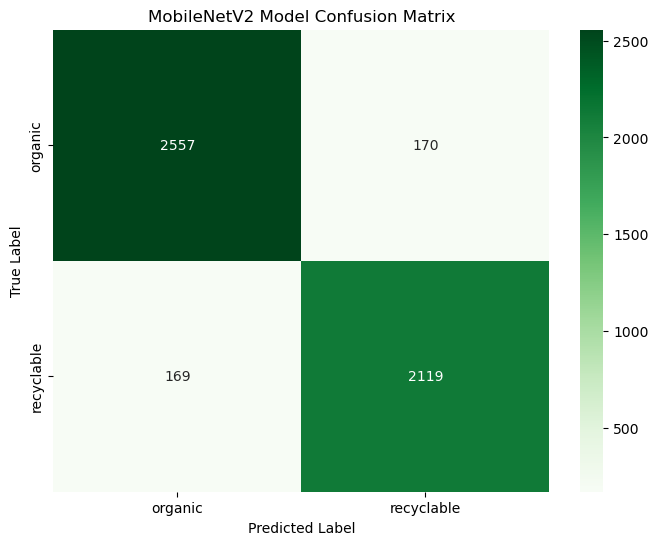

In [40]:
#Evaluate the MobileNetV2 model's performance

#Import the evaluation report & metrics
from sklearn.metrics import classification_report, confusion_matrix

# Extract true class labels from the directory structure
val_true_classes = []
for _, labels in val_ds2:
    val_true_classes.extend(labels.numpy())  # Extract true labels

# Define class names
class_names = ['organic', 'recyclable']

# Print classification report
report = classification_report(val_true_classes, val_pred_classes_mnetv2, target_names=class_names)
print("MobileNetV2 Model Classification Report:\n", report)

# Calculate confusion matrix
confusion_mat = confusion_matrix(val_true_classes, val_pred_classes_mnetv2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MobileNetV2 Model Confusion Matrix')
plt.show()

(32, 224, 224, 3)
(32,)


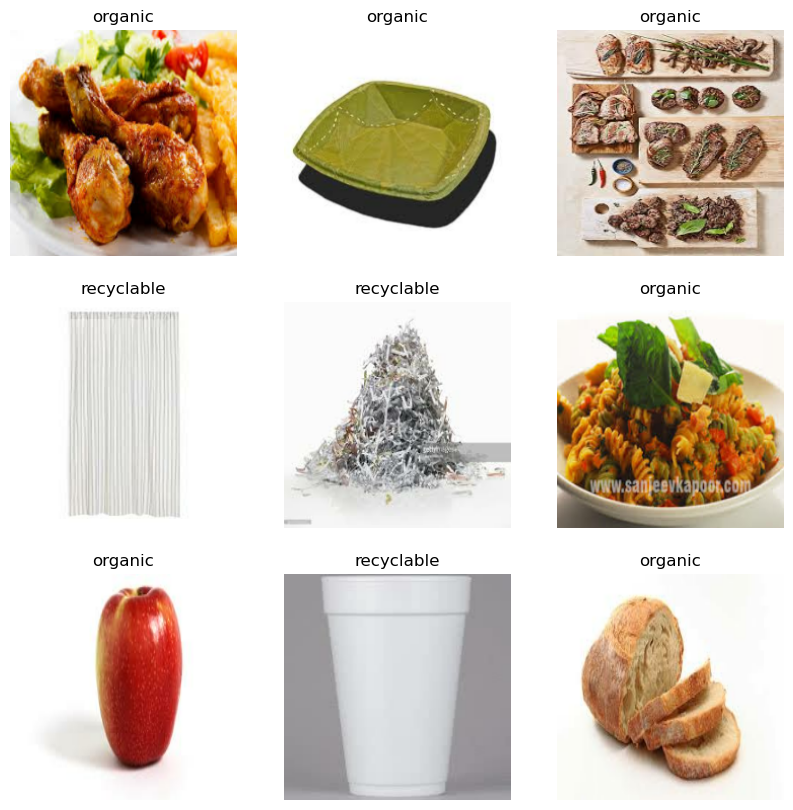

In [41]:
#printing sample waste images (labels) from the train_ds2

plt.figure(figsize=(10, 10))

for images, labels in train_ds2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds2:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


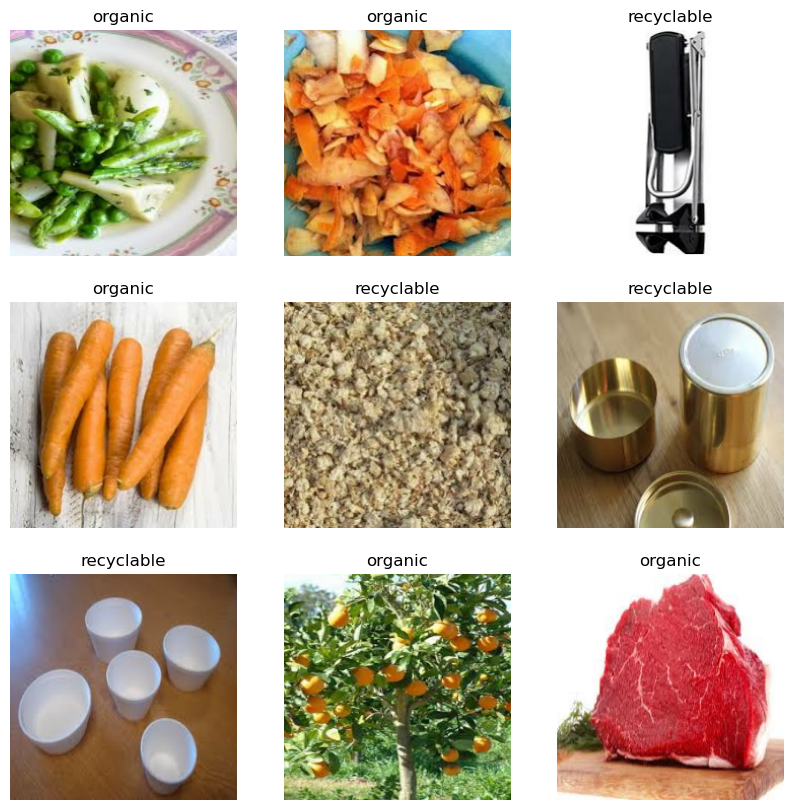

In [42]:
#printing sample waste images (labels) from the val_ds2

plt.figure(figsize=(10, 10))

for images, labels in val_ds2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in val_ds2:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

### CNN MODEL BUILDING

In [43]:
#Loading the dataset and assigning path
data_path = "C:/Users/Helen/Downloads/Waste Classification Data"

In [44]:
#setting parameters for pre-processing data
batch_size = 32
img_height = 180
img_width = 180

In [45]:
#Assigning the preprocessed data to a training dataset variable with parameters
#identifying the classes in the dataset
#splitting dataset into training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path,validation_split=0.2,subset="training",seed=123,
image_size=(img_height, img_width),batch_size=batch_size)

Found 25077 files belonging to 2 classes.
Using 20062 files for training.


In [46]:
#Assigning the preprocessed data to a validating dataset variable with parameters
#identifying the classes in the dataset
#splitting dataset into validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path,validation_split=0.2,subset="validation",seed=123,
image_size=(img_height, img_width),batch_size=batch_size)

Found 25077 files belonging to 2 classes.
Using 5015 files for validation.


In [47]:
#Assigning & printing the class names in the training dataset
class_names = train_ds.class_names
print(class_names)

['Organic', 'Recyclable']


In [53]:
#Autotuning & normalization to allow for optimum performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#rescalaing data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
num_classes = 2

0.0 1.0


In [69]:
#Build CNN model architecture

cnn_model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.8),  # Dropout layer for regularization
    layers.Dense(num_classes, activation='softmax')
])

#compile CNN model
cnn_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

#print CNN model summary
cnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 259200)            0         
                                                                 
 dense_7 (Dense)             (None, 128)               33177728  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [70]:
#train CNN model
cnn_model = cnn_model.fit(train_ds,validation_data=val_ds,epochs=5)

Epoch 1/5


C:\Users\Helen\anaconda3\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


627/627 [==============================] - 479s 754ms/step - loss: 1.0117 - accuracy: 0.7363 - val_loss: 0.4391 - val_accuracy: 0.8134
Epoch 2/5
627/627 [==============================] - 476s 758ms/step - loss: 0.4791 - accuracy: 0.7916 - val_loss: 0.4081 - val_accuracy: 0.8207
Epoch 3/5
627/627 [==============================] - 481s 767ms/step - loss: 0.4603 - accuracy: 0.7971 - val_loss: 0.4089 - val_accuracy: 0.8277
Epoch 4/5
627/627 [==============================] - 474s 756ms/step - loss: 0.4406 - accuracy: 0.8071 - val_loss: 0.4002 - val_accuracy: 0.8225
Epoch 5/5
627/627 [==============================] - 499s 796ms/step - loss: 0.4330 - accuracy: 0.8126 - val_loss: 0.3966 - val_accuracy: 0.8275


In [71]:
#evaluate the CNN model on the training set
test_loss, test_acc = cnn_model.model.evaluate(train_ds, verbose=2)
print('\nTest accuracy:', test_acc)

627/627 - 131s - loss: 0.3495 - accuracy: 0.8459 - 131s/epoch - 208ms/step

Test accuracy: 0.8458777666091919


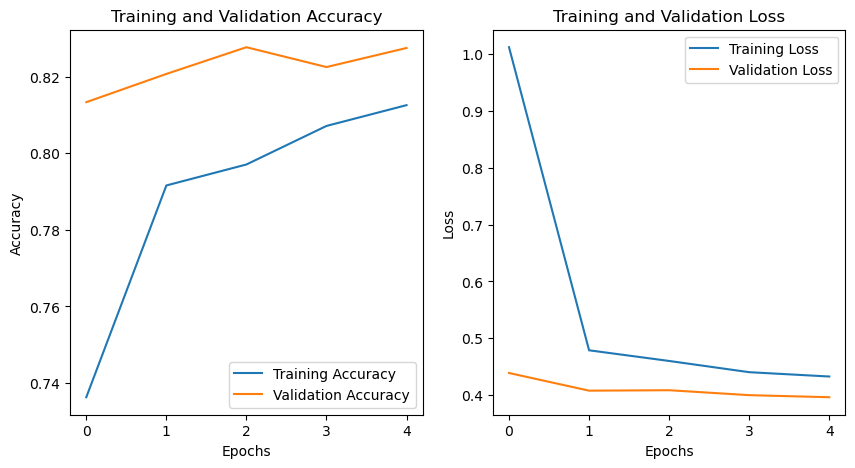

In [72]:
#Visualize loss & accuracy of the CNN model
epochs = 5
acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']
loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [73]:
# Evaluate the CNN model on the validation set
val_loss, val_accuracy = cnn_model.model.evaluate(val_ds)
print(f"Validation accuracy: {val_accuracy:.4f}")

157/157 [==============================] - 35s 223ms/step - loss: 0.3966 - accuracy: 0.8275
Validation accuracy: 0.8275


In [74]:
# Predict classes for the validation set
val_pred_probs_cnn = cnn_model.model.predict(val_ds)
val_pred_classes_cnn = np.argmax(val_pred_probs_cnn, axis=1)

157/157 [==============================] - 27s 164ms/step


CNN Model Classification Report:
               precision    recall  f1-score   support

     organic       0.81      0.89      0.85      2727
  recyclable       0.85      0.75      0.80      2288

    accuracy                           0.83      5015
   macro avg       0.83      0.82      0.82      5015
weighted avg       0.83      0.83      0.83      5015



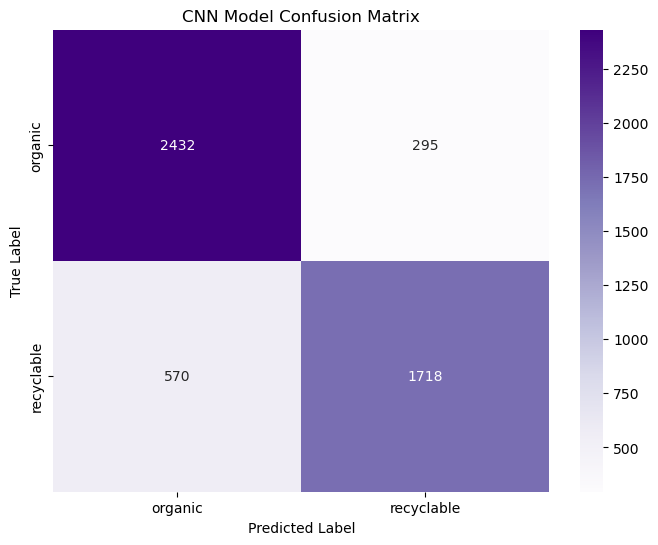

In [148]:
#Evaluate the CNN model's performance

#Import the evaluation report & metrics
from sklearn.metrics import classification_report, confusion_matrix

# Extract true class labels from the directory structure
val_true_classes = []
for _, labels in val_ds:
    val_true_classes.extend(labels.numpy())  # Extract true labels

# Define class names
class_names = ['organic', 'recyclable']

# Print classification report
report = classification_report(val_true_classes, val_pred_classes_cnn, target_names=class_names)
print("CNN Model Classification Report:\n", report)

# Calculate confusion matrix
confusion_mat = confusion_matrix(val_true_classes, val_pred_classes_cnn)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Model Confusion Matrix')
plt.show()

(32, 180, 180, 3)
(32,)


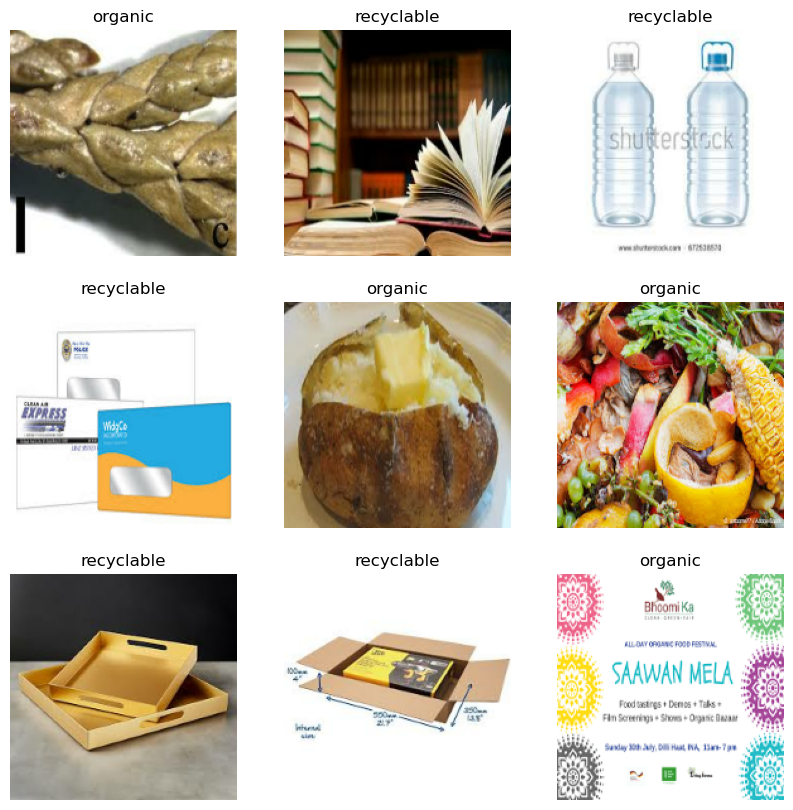

In [76]:
#printing sample waste images (labels) from the train_ds

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


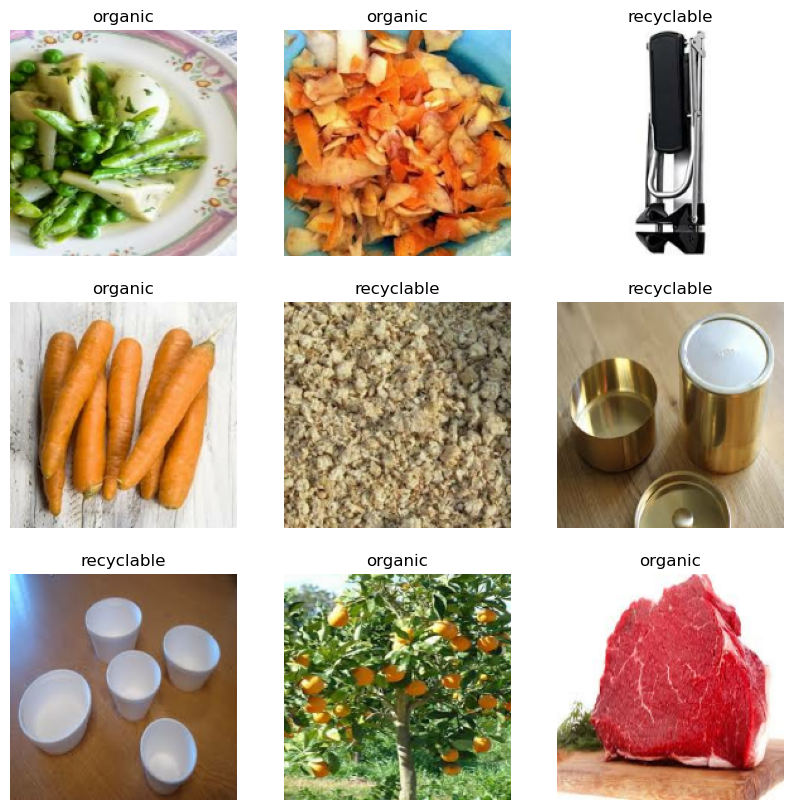

In [77]:
#printing sample waste images (labels) from the val_ds

plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

### Evaluating all models (MLP, MobileNetV2 & CNN) as an Ensemble

In [78]:
#Simple Averaging Ensemble Model

In [79]:
# Evaluating all model's performance by an ensemble on the Training set
cnn_predictions_train = cnn_model.model.evaluate(train_ds)
mlp_predictions_train = mlp_model.model.evaluate(train_ds)
mnetv2_predictions_train = mnetv2_model.model.evaluate(train_ds)

627/627 [==============================] - 346s 552ms/step - loss: 0.1914 - accuracy: 0.9366


In [80]:
# Evaluating all model's performance by an ensemble on the validation set
cnn_predictions_val = cnn_model.model.evaluate(val_ds)
mlp_predictions_val = mlp_model.model.evaluate(val_ds)
mnetv2_predictions_val = mnetv2_model.model.evaluate(val_ds)

157/157 [==============================] - 81s 517ms/step - loss: 0.2109 - accuracy: 0.9268


In [128]:
# Ensemble predictions from the training set
ensemble_predictions_train = np.mean([cnn_predictions_train, mlp_predictions_train, mnetv2_predictions_train], axis=0)
ensemble_predictions_train

array([7.04647865, 0.86520121])

In [129]:
# Ensemble predictions from the validation set
ensemble_predictions_val = np.mean([cnn_predictions_val, mlp_predictions_val, mnetv2_predictions_val], axis=0)
ensemble_predictions_val

array([9.7138403 , 0.84167498])

### Accuracy comparison plot of all models

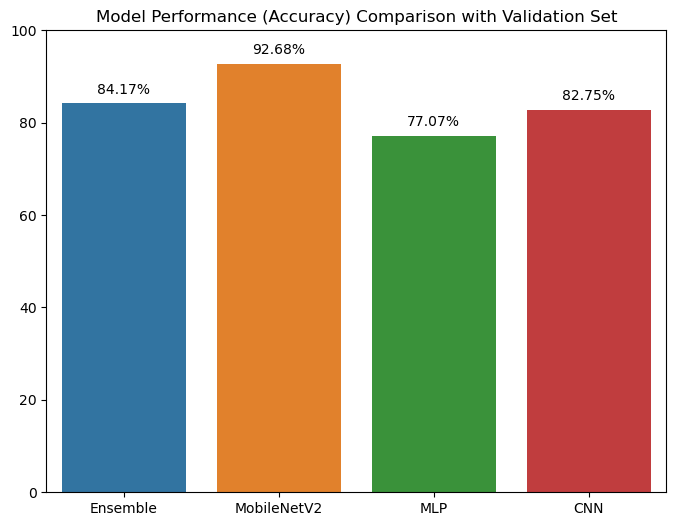

In [134]:
#Validation set comparison bar plot

# Accuracy values
Ensemble_acc = 0.84167498
MobileNetV2_acc = 0.9268
MLP_acc = 0.7707
CNN_acc = 0.8275

# Convert accuracies to percentages
Ensemble_acc_percent = Ensemble_acc * 100
MobileNetV2_acc_percent = MobileNetV2_acc * 100
MLP_acc_percent = MLP_acc * 100
CNN_acc_percent = CNN_acc * 100

# Create a DataFrame for Seaborn
data = {
    'Model': ['Ensemble', 'MobileNetV2', 'MLP', 'CNN'],
    'Accuracy (%)': [Ensemble_acc_percent, MobileNetV2_acc_percent, MLP_acc_percent, CNN_acc_percent]
}

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Accuracy (%)', data=data)
plt.ylim(0, 100)  # Set y-axis limits (accuracy percentage range)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Model Performance (Accuracy) Comparison with Validation Set')
plt.show()


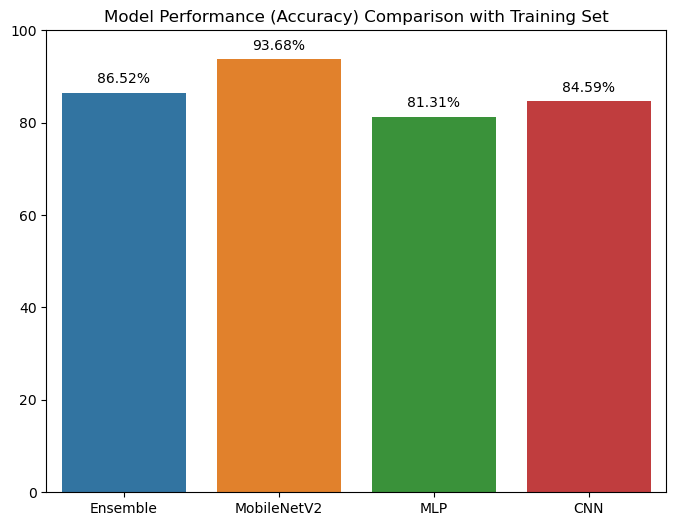

In [138]:
#Training set comparison plot

# Accuracy values
Ensemble_acc_tr = 0.86520121
MobileNetV2_acc_tr = 0.9368
MLP_acc_tr = 0.8131
CNN_acc_tr = 0.8459

# Convert accuracies to percentages
Ensemble_acc_tr_percent = Ensemble_acc_tr * 100
MobileNetV2_acc_tr_percent = MobileNetV2_acc_tr * 100
MLP_acc_tr_percent = MLP_acc_tr * 100
CNN_acc_tr_percent = CNN_acc_tr * 100

# Create a DataFrame for Seaborn
data = {
    'Model': ['Ensemble', 'MobileNetV2', 'MLP', 'CNN'],
    'Accuracy (%)': [Ensemble_acc_tr_percent, MobileNetV2_acc_tr_percent, MLP_acc_tr_percent, CNN_acc_tr_percent]
}

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Model', y='Accuracy (%)', data=data)
plt.ylim(0, 100)  # Set y-axis limits (accuracy percentage range)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Model Performance (Accuracy) Comparison with Training Set')
plt.show()
